# Baseline Models

Here we walk through some data exploration and do work on our baseline models.

The outline is as follows:

* Look at data and run simple logistic regression classifer on data
* Try resampling methods using this classifer 
* Implement other baseline classifiers using the best resampling technique 
* See briefly what tuning can be done


### Imports and printing utility


In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import itertools

from IPython.core.display import HTML

HTML("""
<style>
 {
    display: table-cell;
    text-align: center;
   .output_png vertical-align: middle;
}
</style>
""")

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        1#print('Confusion matrix, without normalization')

    #print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    

This is a function that prints a nice plot of the confusion matrix, that'll be useful to use later on.

### Read in Data

In [20]:
data = pd.read_csv("creditcard.csv")
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


As we can see, the features have been normalised, except Time and Amount.

### View data balance

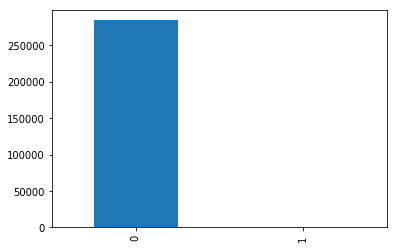

0    284315
1       492
Name: Class, dtype: int64


In [21]:
# Print a plot of class balance
classes = pd.value_counts(data['Class'], sort=True).sort_index()
classes.plot(kind = 'bar')
plt.show()
print classes

### Normalise the Amount column and drop the Time column and the old Amount column

In [22]:
# Normalise and reshape the Amount column, so it's values lie between -1 and 1
from sklearn.preprocessing import StandardScaler
data['norm_Amount'] = StandardScaler().fit_transform(data['Amount'].reshape(-1,1))

# Drop the old Amount column and also the Time column as we don't want to include this at this stage
data = data.drop(['Time', 'Amount'], axis=1)

data.head()

/Users/HarryG1/Documents/University/Year_3/DeepLearning-CreditCardFraud/devEnv/lib/python2.7/site-packages/ipykernel_launcher.py:3: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  This is separate from the ipykernel package so we can avoid doing imports until


,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Class,norm_Amount
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0,0.244964
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0,-0.342475
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0,1.160686
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0,0.140534
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0,-0.073403


---
## Logistic regression (without sampling)
---
Let's setup a logistic regression classifier to run on our data.

### Imports and classifer instantiation 

In [23]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import confusion_matrix,precision_recall_curve,auc,roc_auc_score,roc_curve,recall_score,classification_report 

# Call the logistic regression model with a certain C parameter
lr = LogisticRegression(C = 10)

### Assign data to x and y and perform a train-test split on the data

In [24]:
# Assign variables x and y corresponding to row data and it's class value
X = data.ix[:, data.columns != 'Class']
y = data.ix[:, data.columns == 'Class']

# Whole dataset, training-test data splitting
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.3, random_state = 0)

/Users/HarryG1/Documents/University/Year_3/DeepLearning-CreditCardFraud/devEnv/lib/python2.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  


### Here we perform cross validation
The reason we do this is so we compute an average of runs of our classifier, to be confident in it's results. The scoring metric here is defined as Recall as this is the metric we are most interested in. If you wanted the whole confusion matrix metrics performed under cross-val then you would need to essentially run cross-val yourself, looping over iterations and storing the matrix results. For the purposes of this, we'll just look at Recall.

In [25]:
# CROSS VALIDATION
scores = cross_val_score(lr, X, y, scoring='recall', cv=5)
print scores
print 'Recall mean = ', np.mean(scores)

[ 0.74747475  0.63636364  0.42857143  0.68367347  0.51020408]
Recall mean =  0.601257472686


### Fit the data in a single run and print a confusion matrix
This is just a single run for the purposes of printing a confusion matrix to give us a visualisation of how the classifer performed.

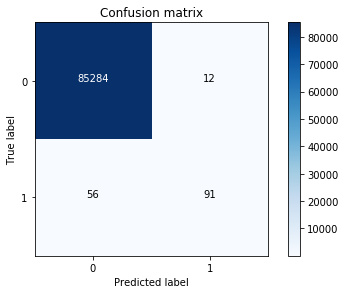

In [26]:
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
class_names = [0,1]


plt.figure()
plot_confusion_matrix(cm, classes=class_names, title='Confusion matrix')
plt.show()

### Print classification report

In [27]:

from sklearn.metrics import classification_report
print classification_report(y_test, y_pred)

             precision    recall  f1-score   support

          0       1.00      1.00      1.00     85296
          1       0.88      0.62      0.73       147

avg / total       1.00      1.00      1.00     85443



---
### Evaluation

So, as we can see, without any sampling techniques on the data, running a simple logistic regression gives us a recall score average of around 60%. 

This is pretty bad. That means that nearly 40% of fraudlent cases were incorrectly predicted. 

---

---
## Aside on C parameter of Logistic regression
---
The C parameter of the logistic regression is essentially a regularisation parameter. Increasing the regularisation strength penalises "large" weight coefficients. This is mainly so that the model performs better on unseen data and avoids learning anomolies or noise.

#### To determine the best value to give this parameter we can do a quick hyper-parameter tuning, namely Grid Search, to find the best value to use:

In [28]:
from sklearn.model_selection import GridSearchCV

# Call the logistic regression model with a certain C parameter
lr = GridSearchCV(LogisticRegression(C = 0.01), {'C':[0.01, 0.1, 1, 10, 100]}, scoring='recall')

# Assign variables x and y corresponding to row data and it's class value
X = data.ix[:, data.columns != 'Class']
y = data.ix[:, data.columns == 'Class']

# # Whole dataset, training-test data splitting
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.3, random_state = 0)

lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

# cm = confusion_matrix(y_test, y_pred)
# class_names = [0,1]

print("Best parameters set found on development set:")
print ""
print(lr.best_params_)
print ""
print("Grid scores on development set:")
print ""
means = lr.cv_results_['mean_test_score']
stds = lr.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, lr.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))
print ""

print("Detailed classification report:")
print ""
print classification_report(y_test, y_pred)
print ""
print("The model is trained on the full development set.")
print("The scores are computed on the full evaluation set.")
print ""


Best parameters set found on development set:

{'C': 10}

Grid scores on development set:

0.583 (+/-0.150) for {'C': 0.01}
0.606 (+/-0.110) for {'C': 0.1}
0.620 (+/-0.107) for {'C': 1}
0.623 (+/-0.122) for {'C': 10}
0.623 (+/-0.122) for {'C': 100}

Detailed classification report:

             precision    recall  f1-score   support

          0       1.00      1.00      1.00     85296
          1       0.88      0.62      0.73       147

avg / total       1.00      1.00      1.00     85443


The model is trained on the full development set.
The scores are computed on the full evaluation set.



#### So we can see here that C=10 is the best value to use.

---
## Undersampling 
---
#### Here, we will attempt undersampling by reducing the number of the majority class, down to a 50:50 ratio with the minority class

Number of frauds 492
number of non fraud:  284315
non_fraud after:  492
[ 0.95652174  0.88405797  0.82608696  0.94117647  0.92647059]
Recall mean =  0.906862745098


/Users/HarryG1/Documents/University/Year_3/DeepLearning-CreditCardFraud/devEnv/lib/python2.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


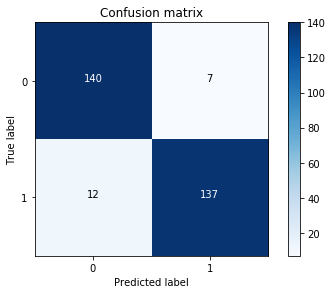

             precision    recall  f1-score   support

          0       0.92      0.95      0.94       147
          1       0.95      0.92      0.94       149

avg / total       0.94      0.94      0.94       296



In [29]:
fraud_indices = np.array(data[data.Class == 1].index)
print 'Number of frauds', len(fraud_indices)

non_fraud = data[data.Class==0]
fraud = data[data.Class==1]

print 'number of non fraud: ', len(non_fraud)
non_fraud = non_fraud.loc[np.random.choice(non_fraud.index, len(fraud_indices), replace=False)]

undersampled_data = pd.concat([non_fraud, fraud])
print 'non_fraud after: ', len(non_fraud)

# Call the logistic regression model with a certain C parameter
lr = LogisticRegression(C = 10)

# Assign variables x and y corresponding to row data and it's class value
X = undersampled_data.ix[:, data.columns != 'Class']
y = undersampled_data.ix[:, data.columns == 'Class']

# Whole dataset, training-test data splitting
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.3, random_state = 0)

# CROSS VALIDATION
scores = cross_val_score(lr, X_train, y_train, scoring='recall', cv=5)
print scores
print 'Recall mean = ', np.mean(scores)

lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
class_names = [0,1]


plt.figure()
plot_confusion_matrix(cm, classes=class_names, title='Confusion matrix')
plt.show()

from sklearn.metrics import classification_report
print classification_report(y_test, y_pred)



### Evaluation 

#### As we can see, by bringing the data to a 50:50 ratio, we bring the recall performance up to 88% average! up from 60%.
This is a significant increase.

---
## Oversampling 
---

Next, we want to try oversampling techniques. This is where the minority class (the fraudulent cases) is scaled up in size, to compare more equally with the number of the majority class. 

#### A way we can do this is by random oversampling, which randomly duplicates data. Let's see how this performs...

dataset shape Counter({0: 284315, 1: 492})
Resampled dataset shape Counter({0: 284315, 1: 284315})
[ 0.92187029  0.91875314  0.9214178   0.92129013  0.91963096]
Recall mean =  0.920592463153


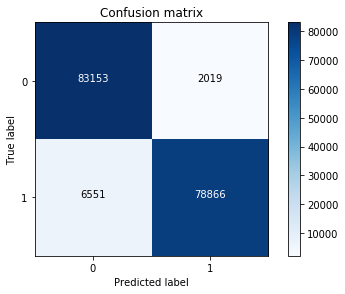

             precision    recall  f1-score   support

          0       0.93      0.98      0.95     85172
          1       0.98      0.92      0.95     85417

avg / total       0.95      0.95      0.95    170589



In [30]:
# Assign variables x and y corresponding to row data and it's class value
X = data.ix[:, data.columns != 'Class']
y = data.ix[:, data.columns == 'Class']

# Setup oversampler and print new data shape
from collections import Counter
from imblearn.over_sampling import RandomOverSampler 
ros = RandomOverSampler(random_state=1)
X_res, y_res = ros.fit_sample(X, y)
print('Original dataset shape {}'.format(Counter(data['Class'])))
print('Training dataset shape {}'.format(Counter(y_train['Class'])))
print('Resampled training dataset shape {}'.format(Counter(y_res)))


# Whole dataset, training-test data splitting
X_train, X_test, y_train, y_test = train_test_split(X_res,y_res,test_size = 0.3, random_state = 0)

# CROSS VALIDATION - NOW ONLY ON TRAINING DATA *
scores = cross_val_score(lr, X_train, y_train, scoring='recall', cv=5)
print scores
print 'Recall mean = ', np.mean(scores)

lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
class_names = [0,1]


plt.figure()
plot_confusion_matrix(cm, classes=class_names, title='Confusion matrix')
plt.show()

from sklearn.metrics import classification_report
print classification_report(y_test, y_pred)

### Evaluation 

#### Oversampling definitely seems to perform slightly better than undersampling here.  We bring the recall performance up to 92% average, fairly conclusively.


### NOTE: However we have to think whether this is wise. Simply duplicating data means that model has potential to cheat. Some of the test data in the test-train split will be the same data as in training. This means that there is likely to be some bias in predictions. 

#### How to overcome? - Instead of oversampling straight away, we should SPLIT the data into test-train FIRST and THEN apply oversampling. This means we have less test data but it is TRUE test data that has not been seen before by the model. 

#### Let's retry this random oversampling but sampling ONLY the training data...

---
## Oversampling ( Preserving test data - oversampling training data only)
---

#### The code will look almost identical to before, just a shift in the order of events:

In [31]:
# Assign variables x and y corresponding to row data and it's class value
X = data.ix[:, data.columns != 'Class']
y = data.ix[:, data.columns == 'Class']

#### Swap the order of data splitting and oversampling

In [37]:
# Whole dataset, training-test data splitting
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.3, random_state = 0)

from collections import Counter
from imblearn.over_sampling import RandomOverSampler 
ros = RandomOverSampler(random_state=1)
X_res, y_res = ros.fit_sample(X_train, y_train)
print('Original dataset shape {}'.format(Counter(data['Class'])))
print('Training dataset shape {}'.format(Counter(y_train['Class'])))
print('Resampled training dataset shape {}'.format(Counter(y_res)))

Original dataset shape Counter({0: 284315, 1: 492})
Training dataset shape Counter({0: 199019, 1: 345})
Resampled training dataset shape Counter({0: 199019, 1: 199019})


#### As we see, the shape of the data is an equal, but less than 284315 split. This is because we are resampling the TRAINING data only. This then leaves 147 fraud cases for testing, as seen in the confusion matric results below.

EXTENSION: Experiment with variations on fraud test data. I.e. Take a lower amount of fraud training data and oversample, leaving more 'True' fraud data for testing and see if there is any better performance.


#### Then do as usual, cross validate and print metrics

[ 0.91483268  0.91596322  0.915511    0.91623957  0.91940306]
Recall mean =  0.916389907562


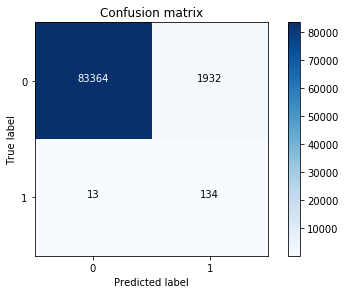

             precision    recall  f1-score   support

          0       1.00      0.98      0.99     85296
          1       0.06      0.91      0.12       147

avg / total       1.00      0.98      0.99     85443



In [33]:
# CROSS VALIDATION
scores = cross_val_score(lr, X_res, y_res, scoring='recall', cv=5)
print scores
print 'Recall mean = ', np.mean(scores)

lr.fit(X_res, y_res)
y_pred = lr.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
class_names = [0,1]


plt.figure()
plot_confusion_matrix(cm, classes=class_names, title='Confusion matrix')
plt.show()

from sklearn.metrics import classification_report
print classification_report(y_test, y_pred)

### Evaluation 

#### Oversampling on training data only seems to perform approximately the same, if not slightly less. This is to be expected however, as the hypothesis was that by oversampling the entire dataset, some of our duplicates were 'leaking' into our test sets which could have created some slight bias. 

#### So for the purposes of Oversampling by Random, duplication, I would conclude that moving forward with the second method is absolutely fine given the intuition and empirical result.

---
## SMOTE ( Preserving test data - oversampling training data only)
---

### Now we try the SMOTE method (Synthetic Minority Oversampling Technique). 
#### This will oversample our minority data in a similar fashion as before, except the new data will be synthetic ones, which means fraudulent data will be slightly modified (i.e noise added, tweak of value etc) to create new examples.

#### The procedure is similar to before, sampling training data only to preserve test data

In [2]:
# Assign variables x and y corresponding to row data and it's class value
X = data.ix[:, data.columns != 'Class']
y = data.ix[:, data.columns == 'Class']


# Whole dataset, training-test data splitting
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.3, random_state = 0)

from collections import Counter
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=1)
X_res, y_res = sm.fit_sample(X_train, y_train)
print('Original dataset shape {}'.format(Counter(data['Class'])))
print('Training dataset shape {}'.format(Counter(y_train['Class'])))
print('Resampled training dataset shape {}'.format(Counter(y_res)))

# CROSS VALIDATION
scores = cross_val_score(lr, X_res, y_res, scoring='recall', cv=5)
print scores
print 'Recall mean = ', np.mean(scores)

lr.fit(X_res, y_res)
y_pred = lr.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
class_names = [0,1]


plt.figure()
plot_confusion_matrix(cm, classes=class_names, title='Confusion matrix')
plt.show()

from sklearn.metrics import classification_report
print classification_report(y_test, y_pred)

NameError: name 'data' is not defined

### Evaluation 

#### Oversampling on training data using SMOTE seems to perform approximately the same. 

---
## Other classifiers
---
Let's now experiment with other classifiers, moving forward with SMOTE oversampled data (performed on training data only).

* K NEAREST NEIGHBORS
* NEURAL NET
* LINEAR SVM 
* DECISION TREE
* NAIVE BAYES
* RANDOM FORREST
* GAUSSIAN PROCESS

K NEAREST NEIGHBORS: 


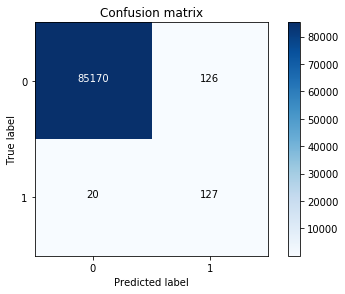

             precision    recall  f1-score   support

          0       1.00      1.00      1.00     85296
          1       0.50      0.86      0.63       147

avg / total       1.00      1.00      1.00     85443

RECALL :  0.863945578231


In [39]:
################## K NEAREST NEIGHBORS ###################
print 'K NEAREST NEIGHBORS: '
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier()

neigh.fit(X_res, y_res)
y_pred = neigh.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
class_names = [0,1]

plt.figure()
plot_confusion_matrix(cm, classes=class_names, title='Confusion matrix')
plt.show()

from sklearn.metrics import classification_report
print classification_report(y_test, y_pred)
print 'RECALL : ', recall_score(y_test, y_pred)

In [40]:
################### NEURAL NET ###################
print 'NEURAL NET: '
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier()

mlp.fit(X_res, y_res)
y_pred = mlp.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
class_names = [0,1]

from sklearn.metrics import classification_report
print classification_report(y_test, y_pred)
print 'RECALL : ', recall_score(y_test, y_pred)

NEURAL NET: 
             precision    recall  f1-score   support

          0       1.00      1.00      1.00     85296
          1       0.75      0.81      0.78       147

avg / total       1.00      1.00      1.00     85443

RECALL :  0.809523809524


In [41]:
################### DECISION TREE ###################
print 'DECISION TREE: '
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier()

dt.fit(X_res, y_res)
y_pred = dt.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
class_names = [0,1]

from sklearn.metrics import classification_report
print classification_report(y_test, y_pred)
print 'RECALL : ', recall_score(y_test, y_pred)

DECISION TREE: 
             precision    recall  f1-score   support

          0       1.00      1.00      1.00     85296
          1       0.39      0.77      0.52       147

avg / total       1.00      1.00      1.00     85443

RECALL :  0.768707482993


In [42]:
################### LINEAR SVM ###################
print 'LINEAR SVM: '
from sklearn.svm import SVC

lin_svm = SVC()

lin_svm.fit(X_res, y_res)
y_pred = lin_svm.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
class_names = [0,1]

from sklearn.metrics import classification_report
print classification_report(y_test, y_pred)
print 'RECALL: ', recall_score(y_test, y_pred)

LINEAR SVM: 
             precision    recall  f1-score   support

          0       1.00      1.00      1.00     85296
          1       0.38      0.69      0.49       147

avg / total       1.00      1.00      1.00     85443

RECALL:  0.69387755102


In [43]:
################### RANDOM FOREST ###################
print 'RANDOM FOREST: '
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()

rf.fit(X_res, y_res)
y_pred = rf.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
class_names = [0,1]

from sklearn.metrics import classification_report
print classification_report(y_test, y_pred)
print recall_score(y_test, y_pred)

RANDOM FOREST: 
             precision    recall  f1-score   support

          0       1.00      1.00      1.00     85296
          1       0.90      0.80      0.84       147

avg / total       1.00      1.00      1.00     85443

0.795918367347


In [1]:
################### NAIVE BAYES ###################
print 'Gaussian Naive Bayes: '
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()

gnb.fit(X_res, y_res)
y_pred = gnb.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
class_names = [0,1]

from sklearn.metrics import classification_report
print classification_report(y_test, y_pred)
print recall_score(y_test, y_pred)

Gaussian Naive Bayes: 


NameError: name 'X_res' is not defined

## Summarising classifiers and averaging runs

#### Here, instead of just training a classifier once and predicting, I create a function that averages results over 3 runs. These 3 runs incoperate a new, fresh random test-train split of the data. In addition, SMOTE is used for every train data, with each iteration. So all three runs are new random tests in the sense that the split of data and resampling is different. We then average the important metrics, to be confident in the results.

#### In a lot of machine learning applications, one may use a similar technique of cross-validation. This is normally preferable on a small subsample of the data to see what classifiers perform best. Seeing as we want to ultimate set baselines for these models, I just run them on the full dataset to get full results.

In [ ]:
def generate_train_test_sample(x_data, y_data): 
    ''' 1) Generate new, random train-test split
        2) Random smote oversample the train data, keeping test data unseen
        3) Use this new train-test split to fit and test model
    '''

    X_train, X_test, y_train, y_test = train_test_split(x_data,y_data,test_size = 0.3)

    from collections import Counter
    from imblearn.over_sampling import SMOTE
    sm = SMOTE()
    X_res, y_res = sm.fit_sample(X_train, y_train)
    print('Resampling the data with SMOTE. . .')
    print('Resampled training dataset shape {}'.format(Counter(y_res)))

    return X_res, y_res, X_test, y_test

In [ ]:
########################################################################
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

classifiers = [
    KNeighborsClassifier(),
    LinearSVC(),
    DecisionTreeClassifier(random_state=0),
    RandomForestClassifier(random_state=0),
    MLPClassifier(),
    GaussianNB()]